<a href="https://colab.research.google.com/github/ffatmanurggultekin/scoliosis-detection/blob/main/Skolyoz_svm_hibrit_v4_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201  # ResNet50 yerine DenseNet201 kullanılıyor
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from google.colab import drive

# ✅ Google Drive'ı bağla
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import scipy.io
import numpy as np

# Dosyanın yolu
load_path = "/content/drive/MyDrive/Skolyoz_calismalari/features_data_imadjust.mat"

# .mat dosyasını yükle
data = scipy.io.loadmat(load_path)

# Verileri numpy dizilerine çevir
train_features = np.array(data["train_features"])
train_labels = np.array(data["train_labels"]).ravel().astype(int)
test_features = np.array(data["test_features"])
test_labels = np.array(data["test_labels"]).ravel().astype(int)

# Kontrol için boyutları yazdır
print(f"train_features shape: {train_features.shape}")
print(f"train_labels shape: {train_labels.shape}")
print(f"test_features shape: {test_features.shape}")
print(f"test_labels shape: {test_labels.shape}")


train_features shape: (180, 1920)
train_labels shape: (180,)
test_features shape: (78, 1920)
test_labels shape: (78,)


<ipython-input-2-2d6051a0ece0>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_labels = np.array(data["train_labels"]).ravel().astype(int)
<ipython-input-2-2d6051a0ece0>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_labels = np.array(data["test_labels"]).ravel().astype(int)


In [ ]:
!pip install hyperopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 19.2 MB/s eta 0:00:00


In [ ]:
# %load /content/drive/MyDrive/svm_optimization.py
"""
Created on Sat Aug 20 12:55:20 2022

@author: nclk
"""
import numpy as np
from numpy import pi
import scipy.io

import sklearn as sk

from sklearn.datasets import make_moons, make_circles, make_classification , load_diabetes , load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_score
import os, time

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK , atpe
from sklearn.metrics import accuracy_score
import sklearn.metrics as mt
import matplotlib.pyplot as plt

#%% VERİ SETİNİN SEÇİLMESİ: Seçilmek istenen veri seti blok arası ctrl+1 ile kod satırına dönüştürülür.

#==============================================================================

# Data klasöründeki dry bean veri seti

# S = scipy.io.loadmat('data//bean_data.mat')
# feat = S['feat']
# lbl  = S['lbl']

#==============================================================================

#feat , lbl = sk.datasets.load_wine(  return_X_y = True)

#==============================================================================

# feat , lbl  = load_breast_cancer(  return_X_y = True)

#==============================================================================

# feat , lbl  = make_moons( n_samples=1000 ,   shuffle=True, noise=0.2, random_state=2)

#==============================================================================

# feat , lbl = sk.datasets.load_iris( return_X_y=True, as_frame=False)

#==============================================================================

# Spiral Veri Seti
# N = 500
# theta = np.sqrt(np.random.rand(N))*4*pi # np.linspace(0,2*pi,100)

# r_a = 2*theta + pi
# data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
# x_a = data_a + 2*np.random.randn(N,2)

# r_b = -2*theta - pi
# data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
# x_b = data_b + 2*np.random.randn(N,2)

# res_a = np.append(x_a, np.zeros((N,1)), axis=1)
# res_b = np.append(x_b, np.ones((N,1)), axis=1)

# res = np.append(res_a, res_b, axis=0)
# np.random.shuffle(res)

# feat = res[:, :2]
# lbl  = res[:,2]

# plt.figure()
# plt.scatter(x_a[:,0],x_a[:,1])
# plt.scatter(x_b[:,0],x_b[:,1])
# plt.show()

#==============================================================================

# Eğitim ve test oranının belirlenmesi,
# random_state ile her zaman aynı rastgele sayılar üretilerek kodların aynı değerler üretmesi sağlanır.

#tst_ratio = 0.90
#rng_numb  = 1

#X_train, X_test, Y_train, Y_test = \
 #       train_test_split(feat, lbl, test_size= tst_ratio , random_state = rng_numb)
X_train=train_features
X_test=test_features
Y_train=train_labels
Y_test=test_labels

#%%
"""
Bu aşamada kernel tipi belirlenir.
Eğer kernel 2 veya 3 parametre içeriyorsa argüman kısmına param2 ve 3 eklenmelidir.
Eğer kernel içerisinde mesafe l2-norm harici birşey ise f_dot olan yere fonksiyonun
kendisi yazılabilir. Aşağıda toplam 5 adet kernel bulunmaktadır. Polynomial kerneli de ekleyebiliriz

"""
f_dot = lambda ux , vy :   ux.dot(vy)

def svm_kernel( param1): #   , param2 , param3

    def kernel_type(X1, X2):

        #D1 = cdist(X1 , X2 , 'euclidean' )

        #D2 = cdist(X1 , X2 , 'euclidean' )**2

        D3 = cdist(X1 , X2 , f_dot )

        G=param1*D3   #linear


        #G=  np.sum((X1[:, np.newaxis, :] * X2[np.newaxis, :, :])**2, axis=2) #anova
        #G=param1*D3/np.sqrt(X1.dot(X1.T))/np.sqrt(X2.dot(X2.T))

        #G=(param1*D3+param2)**2 #quadratic

        #G = np.exp(-D1/param1 )                                       # laplace


        #G = np.exp(-param1*D2)                                        # rbf

        #G = np.tanh( param1 * D3 + param2 )                           # tanh



        #G  = np.log( (D2 + np.exp(1)*param1 ) / (D2 + param1 ) );     # log



        return G

    return kernel_type



#%% Veri normalizasyonu

#==============================================================================

# Buradaki blok ile veri zscore'a göre normalize edilmektedir.

tr_mean     = np.mean( X_train , axis = 0)
X_train_zm  = X_train - tr_mean[None , :]
tr_stdv     = np.std(X_train_zm , axis = 0 )
X_train_st  = X_train_zm/tr_stdv[None,:]


X_test_zm  = X_test - tr_mean[None,:]
X_test_st  = X_test_zm/tr_stdv[None,:]

#==============================================================================

# Eğer normalizasyon istenmez ise aşağıdaki kod aktif edilebilir.


#X_test_st  = X_test
#X_train_st = X_train

#%% Tasarlanan kernel'e göre optimize edilecek olan üst parametrelerin oluşturulması
# Bu kısımda svm kaç parametre içeriyorsa o kadar üst parametre optimizasyona verilmektedir.

N_iter = 1
N_eval = 100

acc_list = np.zeros(N_iter)
fsm_list = np.zeros(N_iter)
svn_list = np.zeros(N_iter) # support vector number

tmr_list = np.zeros(N_iter) # eğitim zamanı

for hyper_iter in range(N_iter):
    tmp_func = svm_kernel

    params = [[] ]

    if tmp_func.__code__.co_argcount == 3:

        params[0] = {
                    'C' :  hp.uniform('C', 1e-2,100  ),

                    'p1':  hp.uniform('p1', 1e-2,100  ),

                    'p2':  hp.uniform('p2', 1e-2,100  ),

                    'p3':  hp.uniform('p3', 1e-2,100  ),

                    }

    elif tmp_func.__code__.co_argcount == 2:

        params[0] = {
                    'C' :  hp.uniform('C', 1e-2,100  ),

                    'p1':  hp.uniform('p1', 1e-2,100  ),

                    'p2':  hp.uniform('p2', 1e-2,100  )

                    }

    else:
        params[0] = {
                    'C' :  hp.uniform('C', 1e-2,100  ),

                    'p1':  hp.uniform('p1', 1e-2,100  )

                    }


    def classification_loss(params):

        C  = params[0]['C']
        p1 = params[0]['p1']

        if len(params[0]) == 4:
            p2 = params[0]['p2']
            p3 = params[0]['p3']

            clf = sk.svm.SVC(C = C , kernel = svm_kernel( param1 = p1 , param2 = p2 , param3 = p3 ) )

        elif len(params[0]) == 3:
            p2 = params[0]['p2']
            clf = sk.svm.SVC(C = C , kernel = svm_kernel( param1 = p1 , param2 = p2 ) )

        else:
            clf = sk.svm.SVC(C = C , kernel = svm_kernel( param1 = p1 ) )

        # cross_val_score fonksiyonu val_scr olarak accuracy çıkarmaktadır.
        # bu nedenle optimizasyonun minimumu bulabilmesi için ortalama değer 1'den çıkarılmıştır.

        val_scr = cross_val_score(clf, X_train_st , Y_train.ravel() , cv=5)

        return 1- np.mean( val_scr )


    def hypopt_regressor(params):
        opt_loss = classification_loss(params)
        print(params)
        return {'loss': opt_loss, 'status': STATUS_OK}



    trials           = []
    trials           = Trials();
    crossVal_str_tmr = time.time()

    max_evals  = N_eval
    algorithm  = tpe.suggest # atpe.suggest

    best    = []

    best    = fmin(hypopt_regressor,
                    params,
                    algo         = algorithm,
                    max_evals    = max_evals,
                    trials       = trials)
    crossVal_stp_tmr = time.time()

    cvt_time = (crossVal_stp_tmr - crossVal_str_tmr)

    tmr_list[hyper_iter] = cvt_time

    print(best)

    print('Geçen süre: ' , str(cvt_time))



    if  len(best) == 4:
        clf = sk.svm.SVC(C = best['C'], kernel = svm_kernel( param1= best['p1'] , param2= best['p2'] , param3= best['p3']))

    elif len(best) == 3:
        clf = sk.svm.SVC(C = best['C'], kernel = svm_kernel( param1= best['p1'] , param2= best['p2'] ) )

    elif len(best) == 2:
        clf = sk.svm.SVC(C = best['C'], kernel = svm_kernel( param1 = best['p1'] ) )

    clf.fit(X_train_st , Y_train.ravel())

    # cross_val_score fonksiyonundan dönen hata değerleri
    val_scr = cross_val_score(clf, X_train_st, Y_train.ravel(), cv=3)

    # Ortalama hata ve standart sapma hesaplama
    mean_error = np.mean(val_scr)
    std_error = np.std(val_scr)

    print(f"Eğitim hatalarının ortalaması: {mean_error:.4f}")
    print(f"Eğitim hatalarının standart sapması: {std_error:.4f}")


    pre_gnd = clf.predict(X_test_st)

    print(accuracy_score( Y_test.ravel(), pre_gnd.ravel() ) )
    print(mt.f1_score(    Y_test.ravel(), pre_gnd.ravel() , average = "macro"))
    print( len(clf.support_) )

    acc_list[hyper_iter] = accuracy_score( Y_test.ravel(), pre_gnd.ravel() )
    fsm_list[hyper_iter] = mt.f1_score(    Y_test.ravel(), pre_gnd.ravel() , average = "macro")
    svn_list[hyper_iter] = len(clf.support_)
    print(acc_list)




({'C': 79.0771809770564, 'p1': 20.98205268477476},)
({'C': 70.21985399797306, 'p1': 15.130588154420323},)
({'C': 62.38996151589055, 'p1': 5.345666580358078},)
({'C': 45.00188060462725, 'p1': 70.6220523829039},)
({'C': 6.477543024431941, 'p1': 23.67064425169643},)
({'C': 22.719053713565458, 'p1': 59.64595258568036},)
({'C': 94.34379353786655, 'p1': 77.88579484995962},)
({'C': 61.926100799377544, 'p1': 67.94846160024552},)
({'C': 3.92190411690663, 'p1': 63.85727298553667},)
({'C': 20.26857192890888, 'p1': 71.67045989091191},)
({'C': 27.611850579115217, 'p1': 87.68571427567247},)
({'C': 63.38042381043625, 'p1': 63.42418384566501},)
({'C': 35.046564278582906, 'p1': 24.136160415394848},)
({'C': 50.65473275924587, 'p1': 0.7727795590730959},)
({'C': 60.895884898052145, 'p1': 65.02689185171391},)
({'C': 4.728186622372805, 'p1': 78.18756691105652},)
({'C': 7.605864984125751, 'p1': 70.34547369344067},)
({'C': 3.877684446248557, 'p1': 40.05238965913359},)
({'C': 70.543359826736, 'p1': 64.44689326

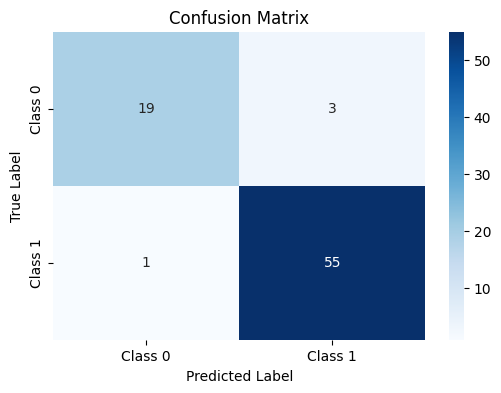

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix hesapla
cm = confusion_matrix(Y_test.ravel(), pre_gnd.ravel())

# Matplotlib ve Seaborn ile görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#%% Eğer veri 2 boyutlu ise karar yüzeyi çizdirilmek için aşağıdaki kod bloğu kullanılabilir.


def make_meshgrid(x, y, h= 0.01 ):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


fig, ax = plt.subplots()

X0, X1 = X_train_st[:, 0], X_train_st[:, 1]

xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

ax.scatter(X0, X1, c= Y_train , cmap=plt.cm.coolwarm, s=20, edgecolors="k")

ax.set_xticks(())
ax.set_yticks(())

plt.show()

